코랩 런타임 > 런타임 유형 변경 GPU 로 설정 후 과제 진행해주세요 !

# < 4주차 과제 >
- 원하는 구조를 가진 CNN을 구축할 수 있다
- 실전적인 이미지 데이터셋을 활용하여 분류 Task를 수행해보자.

In [28]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Baseline (복습)

In [ ]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 37036284.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99618169.26it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12156068.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # 1 input, 10 output
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 10 input, 20 output
    self.mp = nn.MaxPool2d(2) # max-pooling layer with kernel_size 2

    self.fc = nn.Linear(20*4*4, 10)
    # Input size is the number of features produced by the last conv layer
    # 20 channels with a spatial size of 4*4

  def forward(self, x):
    # Assigning batch size, how many examples in the current batch
    in_size = x.size(0) # Extracts the size of batch

    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))

    # Flatten the feature map before the fully connected layer
    x = x.view(in_size, -1)

    # Apply the fully connected layer
    x = self.fc(x)

    return F.log_softmax(x)

In [ ]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
# SGD optimizer
# model.parameter() : 최적화에 필요한 변수들 모두 제공, 옵티마이저가 이 파라미터들을 계속 업데이트
# learning rate = 0.01
# momentum = 0.5 : SGD를 진동을 감소시키는 방향으로 강화, 지난 업데이트의 영향을 통제

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad() # Gradients 초기화
    output = model(data)

    loss = F.nll_loss(output, target)
    # nll_loss : Negative log likelihood loss, often used in classification prob

    loss.backward() # Backward pass

    optimizer.step() # Update model parameters using gradients

    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

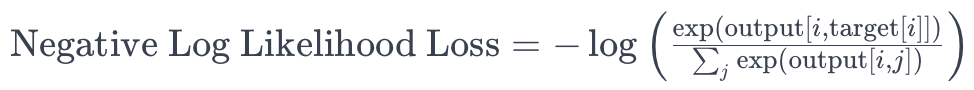

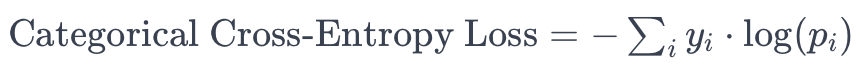

In [ ]:
def test():
    model.eval() # Set model to evaluation mode

    test_loss = 0
    correct = 0

    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        # volatile = True : Gradients do not need to be calculated for
        #                   specific tensors

        output = model(data)

        test_loss += F.nll_loss(output, target, size_average=False).data
        # Negative log likelihood vs Cross entropy loss
        # NLL measures the negative log likelihood of the true class under the
        #   predicted probability distribution
        # Cross-Entropy loss formula contains y_i as a indicator function for
        #   true class, and p_i as the predicted probability for class i
        # In summary, for multi-class classification prob, both fuctions are
        #   equivalent

        # size_avarage = False : Loss won't bee averaged over the batch,
        #                        it will be summed

        # test_loss : Accumulates the calculated loss across multiple batches

        pred = output.data.max(1, keepdim=True)[1]
        # Extracting the predicted class indices for each example in the batch
        #   based on the raw output of the neural network

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        # .eq : Element-wise equality comparison between predicted class and truth class
        # .sum() : Sum of boolean values obtained from .eq, which represents
        #          the total number of correct predictions in the batch

    test_loss /= len(test_loader.dataset) # Normalizing

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-4-da0d988cae1c>:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307361
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306942
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.280024
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.266958
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.251827
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.255501
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.239275
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.203640
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.189027
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.158049
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.096165
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.941439
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.750369
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.604349
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.376756
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.194533
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.027139
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.892574
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.844869
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.938586
Train Epoch: 1 [12800/60000 (

<ipython-input-7-f5d56fc39a56>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1836, Accuracy: 9486/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.197956
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.220082
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.125301
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.218744
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.215894
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.139631
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.103488
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.138086
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.333261
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.387518
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.158260
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.192714
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.332835
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.211178
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.455315
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.164007
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.107909
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.333762
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.140330
Train Epoch: 2 [12

# [4주차 과제 1 : CNN structure 구현하기]
- 3주차 과제에서 맛보았던 baseline 코드를 바탕으로,
- 첨부한 이미지의 structure를 구현해주세요!

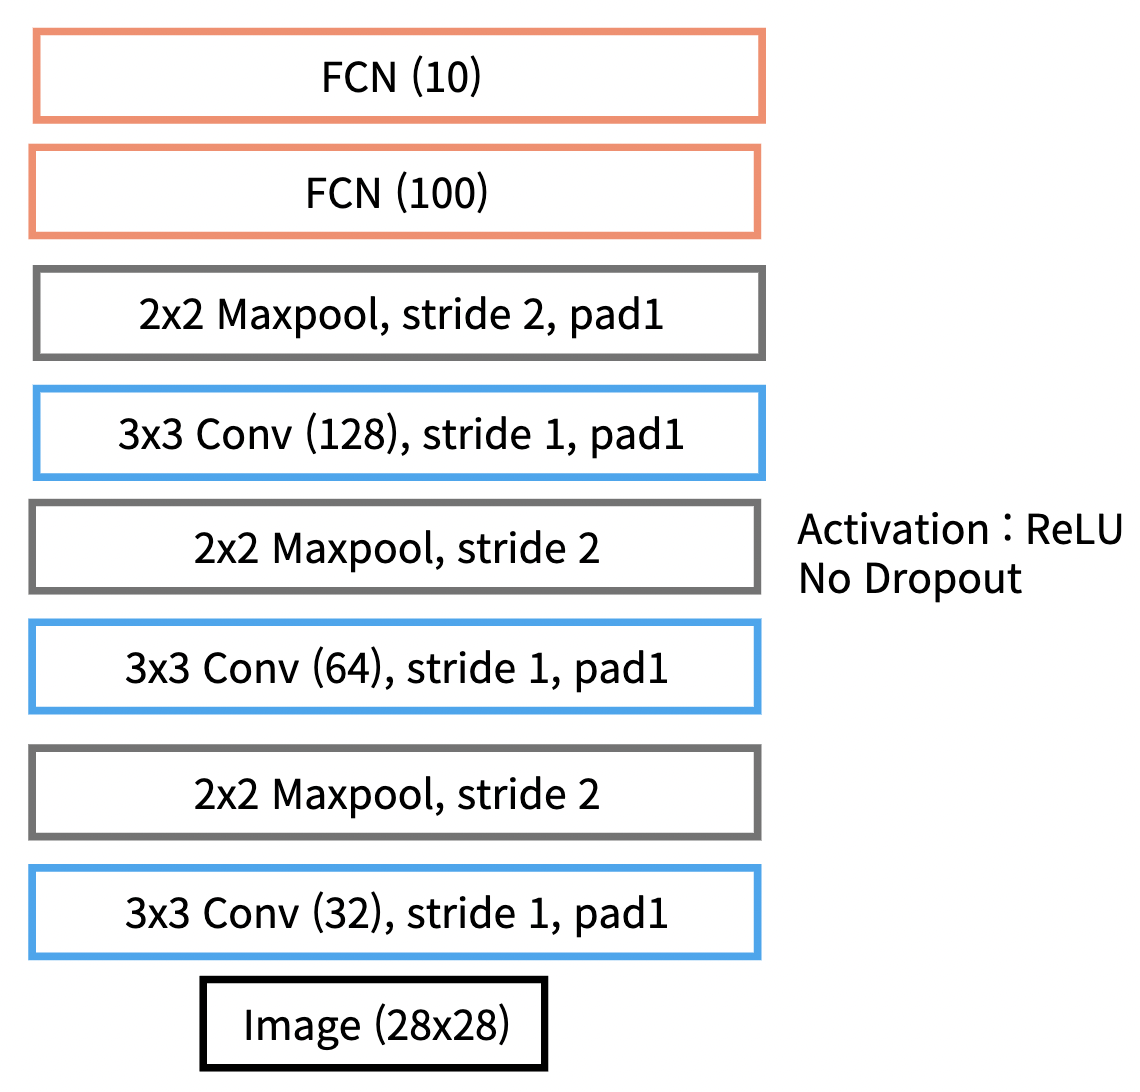

In [ ]:
class revised_Net(nn.Module):
  def __init__(self):
    super(revised_Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(2, stride=2, padding=1) # [(28+2-3) +1] / 2 = 14
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(2, stride=2) # [(14+2-3) + 1] / 2 = 7
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(2, stride=2) # [(7+2-3) + 1 + 1*2] / 2 = 4.5

    # Stride 별로 output이 나오기 때문에 input -> output 점점 증가

    self.fc1 = nn.Linear(128*4*4, 100)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    in_size = x.size(0)

    x = F.relu(self.mp1(self.conv1(x)))
    x = F.relu(self.mp2(self.conv2(x)))
    x = F.relu(self.mp3(self.conv3(x)))
    # Why use pooling before relu?
    # 결과는 같지만, 맥스 풀링을 한 후 계산을 하면 계산량이 줄어듦

    x = x.view(in_size, -1) # 특징 맵 1차원으로 펼침

    x = F.relu(self.fc1(x)) # FC1 레이어 통과 후 100
    x = self.fc2(x)         # FC2 레이어 통과 후 10, 출력 클래스 개수

    return F.log_softmax(x)

In [ ]:
model = revised_Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-12-ba5e593d1067>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304941
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303764
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.282473
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.288623
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.249630
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.257987
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.237696
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.249727
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.200382
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.166113
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.147602
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.059351
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.941645
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.787345
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.464395
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.157194
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.972429
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.898526
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.096460
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.900628
Train Epoch: 1 [12800/60000 (

<ipython-input-13-252edfe1b05a>:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1544, Accuracy: 9531/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.103976
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.385291
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.191877
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.187042
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.199662
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.170266
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.166901
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.105937
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.029514
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.147186
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.284579
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.132329
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.192407
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.064670
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.101355
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.218285
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.116369
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.219504
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.141275
Train Epoch: 2 [12

# [4주차 과제 2 : CNN 활용하기]
- CIFAR 10 데이터셋을 사용하여,
- CNN을 직접 구현하며, 분류 task를 수행해봅시다.

* 지난번 과제와 마찬가지로 다양한 방식을 시도해보시고 그 시도 기록을 남겨주세요. 가장 성능이 좋았던 모델도 표시해주세요

* 이번엔 GPU resource 문제가 생길 수 있습니다. 파라미터 조정, dropout 추가, layer 수 조정 등 연산 효율성도 고려해서 베이스라인 조정해보세요

In [29]:
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 랜덤 시드 고정 : 학습을 위한 실험을 할 때 무작위성을 컨트롤하기 위해 사용.
torch.manual_seed(777) #cpu 연산 고정

if device == "cuda:0":
    torch.cuda.manual_seed_all(777) # 멀티 gpu 연산 무작위 고정

import time
import copy

from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Data Augmentation(데이터 증강) : 원본 데이터를 변형하여 새로운 훈련 샘플을 생성
# 기능 : 과적합을 줄이고 일반화 성능을 향상
# ex) 이미지 데이터 뒤집기, 회정, 색상 변환 등

# Transform(변환) : 데이터에 일련의 조작을 적용하여 전처리

# transforms.Resize : 크기 조정, Transform
# transforms.RandomCrop : 무작위로 부분 이미지 추출, Data Augmentation
# transforms.ToTensor : 텐서로 변환, Transform
# transforms.Normalize : 정규화, Transform

# transforms.Compose : 여러 변환 연결
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomCrop(227), # 227 * 227
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [31]:
batch_size = 64 #batch_size는 원하는 크기로 변경 가능.

cifar_train = datasets.CIFAR10('~/.data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10('~/.data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

data_loaders = {'train' : train_loader, 'val': test_loader}
total_batch = {'train' : len(train_loader), 'val': len(test_loader)}

# Output classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [32]:
class revised_Net(nn.Module):
  def __init__(self):
    super(revised_Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=5) # (227 - 5 + 1) / 4 = 55.75
    self.conv1_bn = nn.BatchNorm2d(16)
    # Batch Normalization helps stabilize and accelerate training

    self.conv2 = nn.Conv2d(16, 32, kernel_size=5) # (55 - 5 + 1) / 4 = 12.75
    self.conv2_bn = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, kernel_size=5) # (12 - 5 + 1) / 4 = 2
    self.conv3_bn = nn.BatchNorm2d(64)

    self.mp = nn.MaxPool2d(2, stride = 4)

    self.fc = nn.Linear(64 * 2 * 2, 10)
    self.fc_bn = nn.BatchNorm1d(10)

    ### Dropout 추가
    # 무작위로 p 만큼의 뉴런 제거 ex) 50%
    # 위치는 Linear층 사이
    # 학습 시간 증가로 일단 주석 처리
    ### self.dropout = nn.Dropout(p=0.5)

    ### self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    in_size = x.size(0)

    x = self.conv1_bn(F.relu(self.conv1(x)))
    x = self.mp(x)
    x = self.conv2_bn(F.relu(self.conv2(x)))
    x = self.mp(x)
    x = self.conv3_bn(F.relu(self.conv3(x)))
    x = self.mp(x)

    x = x.view(in_size, -1)

    # x = F.relu(self.fc1(x))

    x = self.fc_bn(F.relu(self.fc(x)))

    return F.log_softmax(x)

In [33]:
model = revised_Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

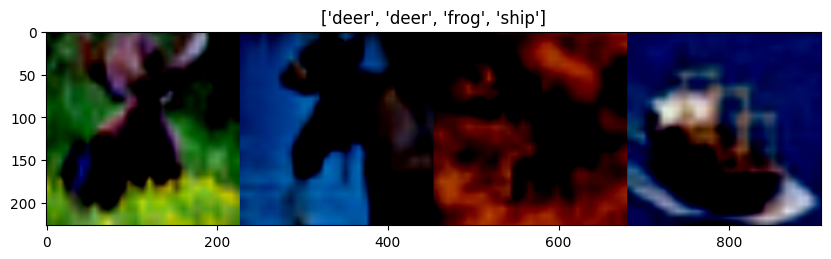

In [34]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(train_loader)   # iter함수로 iteration 객체 가져오기
images, labels = next(dataiter)   # next함수로 다음 배치 1개 갖고오기

# Take four images and arrange them into grid for visualization
img   = utils.make_grid(images[:4], padding=0)

npimg = img.numpy() # numpy 화

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.title([classes[label] for label in labels[:4].tolist()])
plt.show()

In [ ]:
# 시간이 너무 오래 걸려서 우선 epoch 줄임
for epoch in range(1, 2):
    train(epoch)
    test()

<ipython-input-24-b4ab0ef94d34>:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.143151
Train Epoch: 1 [640/50000 (1%)]	Loss: 1.924416
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.009062
Train Epoch: 1 [1920/50000 (4%)]	Loss: 1.789110
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.800325
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.751699
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.817110
Train Epoch: 1 [4480/50000 (9%)]	Loss: 1.912346
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.727511
Train Epoch: 1 [5760/50000 (12%)]	Loss: 1.556180
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.731618
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.624715
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.677831
Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.799183
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.657470
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.531998
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.749586
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.723943
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.654726
Train Epoch: 1 [12160/50000 (24%)]	Loss: 1.705280
Train Epoch: 1 [12800/50000 

<ipython-input-25-252edfe1b05a>:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.5165, Accuracy: 4663/10000 (47%)



In [ ]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-32-055362d2c294>:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.957921
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.086503
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.996286
Train Epoch: 1 [1920/50000 (4%)]	Loss: 1.888395
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.796142
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.827906
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.809009
Train Epoch: 1 [4480/50000 (9%)]	Loss: 1.938763
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.833986
Train Epoch: 1 [5760/50000 (12%)]	Loss: 1.852239
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.687670
Train Epoch: 1 [7040/50000 (14%)]	Loss: 1.696528
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.742279
Train Epoch: 1 [8320/50000 (17%)]	Loss: 1.664215
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.896860
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.823438
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.597754
Train Epoch: 1 [10880/50000 (22%)]	Loss: 1.644791
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.743542
Train Epoch: 1 [12160/50000 (24%)]	Loss: 1.637955
Train Epoch: 1 [12800/50000 

<ipython-input-33-252edfe1b05a>:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 1.5150, Accuracy: 4670/10000 (47%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.319088
Train Epoch: 2 [640/50000 (1%)]	Loss: 1.557821
Train Epoch: 2 [1280/50000 (3%)]	Loss: 1.593409
Train Epoch: 2 [1920/50000 (4%)]	Loss: 1.410016
Train Epoch: 2 [2560/50000 (5%)]	Loss: 1.663823
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.373790
Train Epoch: 2 [3840/50000 (8%)]	Loss: 1.475488
Train Epoch: 2 [4480/50000 (9%)]	Loss: 1.310649
Train Epoch: 2 [5120/50000 (10%)]	Loss: 1.407281
Train Epoch: 2 [5760/50000 (12%)]	Loss: 1.351639
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.348723
Train Epoch: 2 [7040/50000 (14%)]	Loss: 1.405564
Train Epoch: 2 [7680/50000 (15%)]	Loss: 1.298602
Train Epoch: 2 [8320/50000 (17%)]	Loss: 1.266686
Train Epoch: 2 [8960/50000 (18%)]	Loss: 1.476012
Train Epoch: 2 [9600/50000 (19%)]	Loss: 1.810601
Train Epoch: 2 [10240/50000 (20%)]	Loss: 1.405360
Train Epoch: 2 [10880/50000 (22%)]	Loss: 1.451533
Train Epoch: 2 [11520/50000 (23%)]	Loss: 1.562690
Train Epoch: 2 [1